In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.config("spark.driver.memory", "8g").config( "spark.executor.cores", 8).getOrCreate()

In [3]:
def combine_Table(path):
    df =  spark.read.parquet(path + '01')
    for i in range(2,15):
        if i<10:
            i = '0'+str(i)
        else:
            i = str(i)
        df2 = spark.read.parquet(path + i)
        df = df.union(df2)
        df = df.cache()
    return df

In [4]:
def clean_data(df):
    df = df.filter(df.user_id.isNotNull())
    df = df.filter(df.keyword.isNotNull())
    return df

In [5]:
path_T6 = 'C:\\Users\\ddoox\\OneDrive\\Documents\\DataSet\\log_search\\202206'
path_T7 = 'C:\\Users\\ddoox\\OneDrive\\Documents\\DataSet\\log_search\\202207'

data_T6 = combine_Table(path_T6)
data_T7 = combine_Table(path_T7) 

data_T6 = clean_data(data_T6)
data_T7 = clean_data(data_T7)

# Total searchs

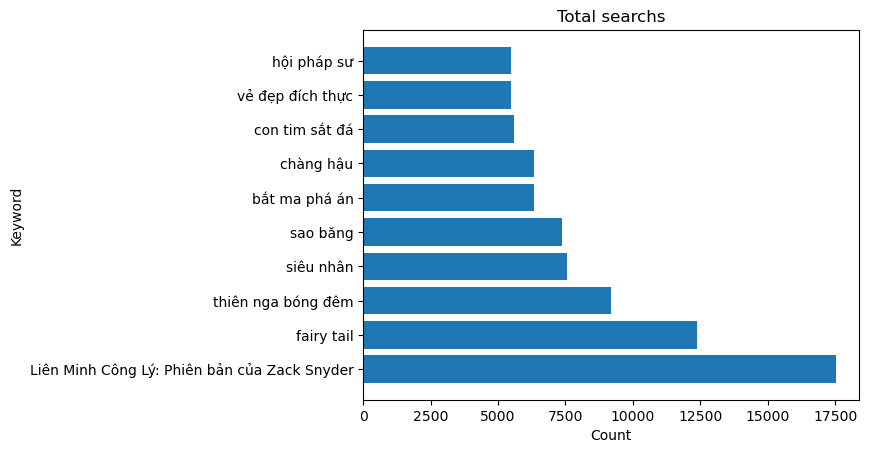

In [6]:
total = data_T6.union(data_T7)
total = total.select("keyword")
total = total.groupBy("keyword").count()
total = total.orderBy("count",ascending=False)
total = total.limit(10)
total = total.toPandas()
plt.barh(total['keyword'], total['count'])
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Total searchs')
plt.show()

# Most watch

In [7]:
def process_Most_Watch(df): 
    df = df.select('user_id','keyword')
    df = df.groupBy('user_id','keyword').count()
    df = df.withColumnRenamed('count','TotalSearch')
    df = df.orderBy('user_id',ascending=False)
    window = Window.partitionBy('user_id').orderBy(col('TotalSearch').desc())
    df = df.withColumn('rank',row_number().over(window))
    df = df.filter(df['rank']==1)
    df = df.select('user_id','keyword')
    df = df.withColumnRenamed('keyword','Most_Watch')
    return df

In [8]:
Most_Watch_T6 = process_Most_Watch(data_T6)
Most_Watch_T7 = process_Most_Watch(data_T7)

In [9]:
Most_Watch_T6 = Most_Watch_T6.withColumnRenamed('Most_Watch','Most_Watch_T6')
Most_Watch_T7 = Most_Watch_T7.withColumnRenamed('Most_Watch','Most_Watch_T7')
Most_Watch = Most_Watch_T6.join(Most_Watch_T7, on='user_id', how='outer')
Most_Watch = Most_Watch.na.drop()
Most_Watch = Most_Watch.groupBy('Most_Watch_T6','Most_Watch_T7').count().orderBy('count',ascending=False)

In [11]:
Most_Watch.limit(10).show(truncate=False)

+--------------------------------------------+--------------------------------------------+-----+
|Most_Watch_T6                               |Most_Watch_T7                               |count|
+--------------------------------------------+--------------------------------------------+-----+
|Liên Minh Công Lý: Phiên bản của Zack Snyder|Liên Minh Công Lý: Phiên bản của Zack Snyder|461  |
|siêu nhân                                   |siêu nhân                                   |229  |
|trữ tình                                    |trữ tình                                    |142  |
|bolero                                      |bolero                                      |138  |
|fairy tail                                  |fairy tail                                  |135  |
|thiếu nhi                                   |thiếu nhi                                   |105  |
|tôi thấy hoa vàng trên cỏ xanh              |tôi thấy hoa vàng trên cỏ xanh              |89   |
|Tìm kiếm bằng giọng

In [13]:
Most_Watch = Most_Watch.withColumnRenamed("Most_Watch_T6","Month 6").withColumnRenamed("Most_Watch_T7","Month 7")
Most_Watch.filter(col("Month 6") != col("Month 7")).limit(10).show(truncate=False)

+--------------------------------------------+------------------------------+-----+
|Month 6                                     |Month 7                       |count|
+--------------------------------------------+------------------------------+-----+
|siêu nhân                                   |tôi thấy hoa vàng trên cỏ xanh|39   |
|tôi thấy hoa vàng trên cỏ xanh              |siêu nhân                     |25   |
|thiên nga bóng đêm                          |anna                          |23   |
|tôi thấy hoa vàng trên cỏ xanh              |taxi, em tên gì?              |16   |
|mộng hoa lục                                |anna                          |16   |
|Liên Minh Công Lý: Phiên bản của Zack Snyder|Kẻ Trộm Mặt Trăng: Minions    |15   |
|fairy tail                                  |hội pháp sư                   |15   |
|bolero                                      |trữ tình                      |14   |
|tôi thấy hoa vàng trên cỏ xanh              |tấm cám: chuyện chưa kể       